In [534]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from collections import defaultdict
from copy import copy
import itertools as it
import json
import os
import re
import sys
import time

import cv2
from gym_minigrid.minigrid import Grid
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import networkx as nx
import numpy as np
import torch
import vizdoom as vzd

from rlpyt.envs.gym import make as gym_make
from rlpyt.models.dqn.dsr.dsr_model import DsrModel
from rlpyt.models.dqn.dsr.tcf_model import TCFModel
from rlpyt.utils.seed import set_seed, make_seed

from itertools import tee, islice
def nwise(iterable, n=2):                                                      
    iters = tee(iterable, n)                                                     
    for i, it in enumerate(iters):                                               
        next(islice(it, i, i), None)                                               
    return zip(*iters)

np.random.seed(333)
device = torch.device('cuda', index=0)

In [1038]:
for _ in range(5):
    print(make_seed())

1723
3270
2561
6335
4445


In [608]:
def render_landmark(obs, title=''):
    plt.figure()
    x, y, _ = np.argwhere(obs == 10)[0]
    obs_copy = obs.copy()
    obs_copy[x, y] = [1, 0, 0]
    grid, _ = Grid.decode(obs_copy)
    d = obs[x, y, 2]
    plt.imshow(grid.render(8, agent_pos=(x, y), agent_dir=d))
    plt.title(title)
    
def get_sf(pos, door_states=None, mean=True, norm=True):
    env.env.unwrapped.agent_pos = pos[:2]
    env.env.unwrapped.agent_dir = pos[2]
    obs = env.get_current_state()[0]
    if door_states is not None:
        assert len(door_states) == len(env.rooms[:-1])
        for room, door_state in zip(env.rooms[:-1], door_states):
            x, y = room.exitDoorPos
            obs[x, y, 2] = door_state
    obs_tensor = torch.Tensor(obs).unsqueeze(0).to(device)
    features = tcf_model(obs_tensor)
    sf = dsr_model(features, mode='dsr')
    if mean:
        sf = sf.mean(dim=1)
    if norm:
        sf = sf / torch.norm(sf, p=2, dim=-1, keepdim=True)
    return obs, sf.detach().cpu().numpy()
    
def get_oracle_distance(pos):
    distance = env.oracle_distance_matrix[pos[0], pos[1], positions[:, 0], positions[:, 1]]
    return distance

In [600]:
with open('../experiments/configs/multiroom.json') as f:
    config = json.load(f)
env_config = config['env']
mode = config['mode']
env = gym_make(mode=mode, minigrid_config=env_config)

In [994]:
landmarks = np.load('../data/local/20200929/minigrid/run_59/landmarks_itr_349999.npz')
weights = torch.load('../data/local/20200929/minigrid/run_59/itr_349999.pkl', map_location=device)

tcf_model = TCFModel(env.observation_space.shape,
                     env.action_space.n, **config['agent']['feature_model_kwargs']).to(device)
dsr_model = DsrModel(env.observation_space.shape,
                     env.action_space.n, **config['agent']['model_kwargs']).to(device)

tcf_model.load_state_dict(weights['agent_state_dict']['feature_model'])
tcf_model.eval()
dsr_model.load_state_dict(weights['agent_state_dict']['model'])
dsr_model.eval()

DsrModel(
  (dsr): MlpModel(
    (model): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=384, bias=True)
    )
  )
  (q_estimate): Linear(in_features=64, out_features=1, bias=True)
)

In [995]:
positions = landmarks['positions']
N = len(positions)

observations = landmarks['observations']
dsr = landmarks['dsr']
norm_dsr = dsr / np.linalg.norm(dsr, ord=2, axis=1, keepdims=True)
dsr_sim = np.matmul(norm_dsr, norm_dsr.T)
features = landmarks['features']
norm_features = features / np.linalg.norm(features, ord=2, axis=1, keepdims=True)
feature_sim = np.matmul(norm_features, norm_features.T)

edge_random_steps = landmarks['edge_random_steps']
edge_random_transitions = landmarks['edge_random_transitions']
edge_subgoal_steps = landmarks['edge_subgoal_steps']
edge_subgoal_failures = landmarks['edge_subgoal_failures']
edge_subgoal_transitions = landmarks['edge_subgoal_transitions']

random_steps = edge_random_steps + np.tril(edge_random_steps, -1).T
random_transitions = edge_random_transitions + np.tril(edge_random_transitions, -1).T

subgoal_steps = edge_subgoal_steps + np.tril(edge_subgoal_steps, -1).T
subgoal_failures = edge_subgoal_failures + np.tril(edge_subgoal_failures, -1).T
subgoal_transitions = edge_subgoal_transitions + np.tril(edge_subgoal_transitions, -1).T

average_random_steps = random_steps / np.clip(random_transitions, 1, None)
average_subgoal_steps = subgoal_steps / np.clip(subgoal_transitions, 1, None)

transitions = random_transitions + subgoal_transitions

In [996]:
dsr_sim[np.eye(N, dtype=bool)] = -1

In [997]:
print('Number of landmarks:', N)
print('Number of non-zero random transitions:', np.argwhere(random_transitions > 0).shape[0])
percentile = 0
threshold = np.percentile(random_transitions[random_transitions > 0], percentile)
print('{} percentile of random transitions:'.format(percentile), 
      threshold)
edge_weights = (random_transitions >= threshold) * (1.0 / np.clip(random_transitions, 1, None))
# edge_weights = (subgoal_transitions > 0) * (1.0 / np.clip(subgoal_transitions, 1, None))

subgoal_edges = np.argwhere(subgoal_transitions > 0)
print('Number of subgoal edges:', subgoal_edges.shape[0])
failure_edges = np.argwhere(subgoal_failures > 0)
print('Number of failure edges:', failure_edges.shape[0])
edges = np.argwhere(edge_weights > 0)
print('Number of edges:', edges.shape[0])

Number of landmarks: 30
Number of non-zero random transitions: 71
0 percentile of random transitions: 1.0
Number of subgoal edges: 11
Number of failure edges: 0
Number of edges: 71


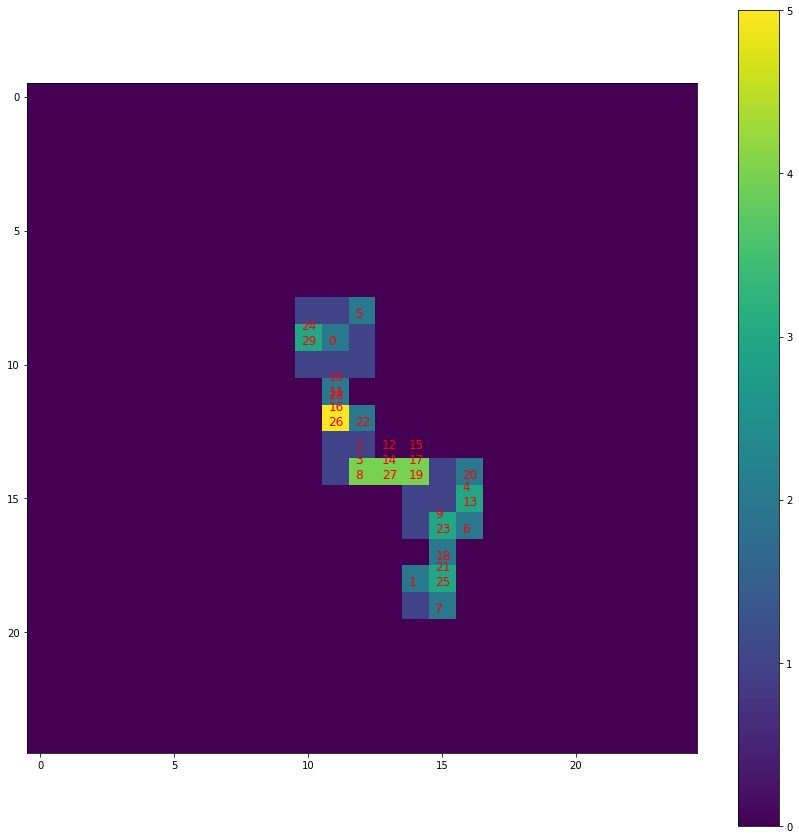

In [998]:
landmarks_grid = np.zeros_like(env.visited)
for x, y in env.get_possible_pos():
    landmarks_grid[x, y] += 1

landmarks_labels = defaultdict(list)
for i, (x, y, d) in enumerate(positions):
    landmarks_labels[(x, y)].append(str(i))
    landmarks_grid[x, y] += 1

plt.figure(figsize=(15, 15))
plt.imshow(landmarks_grid.T)
for (x, y), arr in landmarks_labels.items():
    plt.text(x - 0.25, y + 0.25, '\n'.join(arr), c='red', fontsize=12)
plt.colorbar()

In [1016]:
percentage_out = random_transitions / np.clip(random_transitions.sum(axis=1).reshape(-1, 1), 1, None)

In [1017]:
percentage_out.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1.])

In [1000]:
edge_weights = (random_transitions >= threshold) * percentage_out
edge_weights[edge_weights > 0] = -1 * np.log(edge_weights[edge_weights > 0])

In [1001]:
edge_weights = (random_transitions >= threshold) * (1.0 / np.clip(random_transitions, 1, None))

In [1004]:
path = [0,2,12,1,30]

In [1005]:
def print_path_weight(path):
    total_weight = 0
    for i,j in zip(path[:-2], path[1:]):
        print(i, j, edge_weights[i, j], '{:.2f}%'.format(100 * percentage_out[i, j]))
        total_weight += edge_weights[i, j]
    print('Total weight:', total_weight)

In [1006]:
print_path_weight(path)

0 2 0.14285714285714285 21.88%
2 12 0.016129032258064516 32.46%
12 1 1.0 0.65%
Total weight: 1.1589861751152073


/home/choang/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


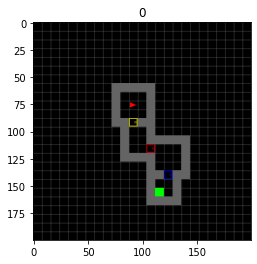

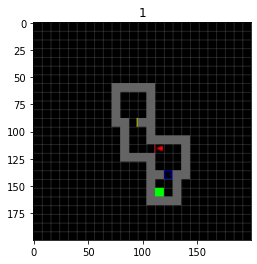

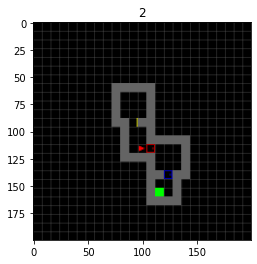

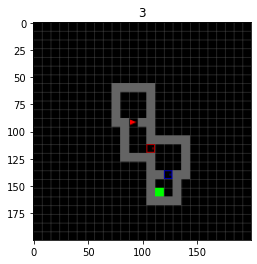

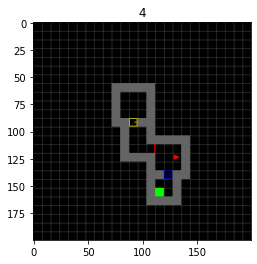

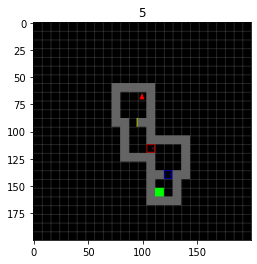

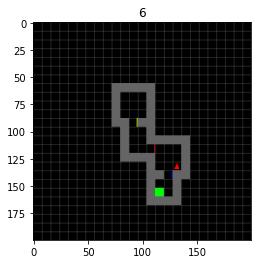

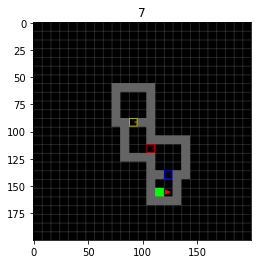

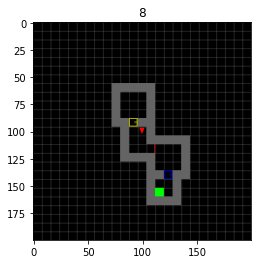

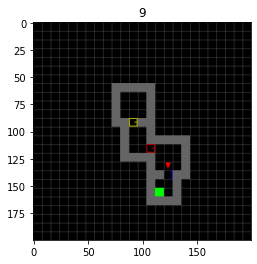

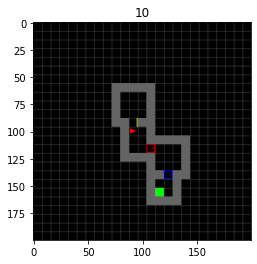

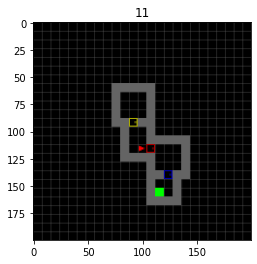

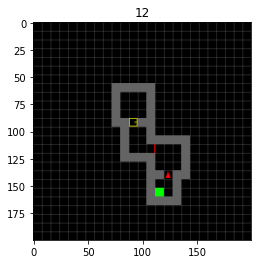

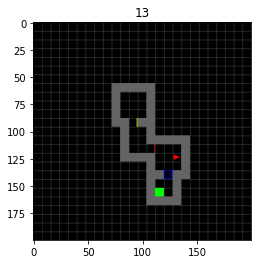

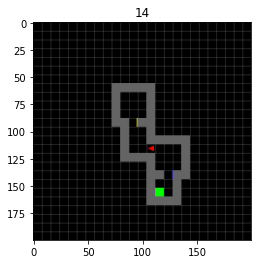

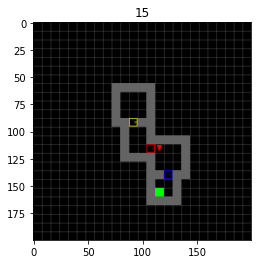

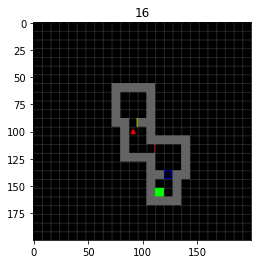

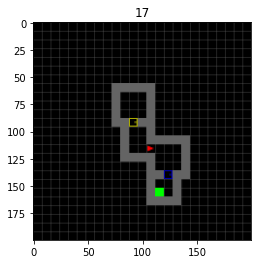

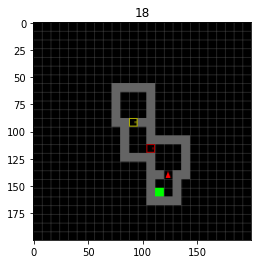

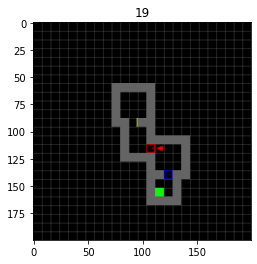

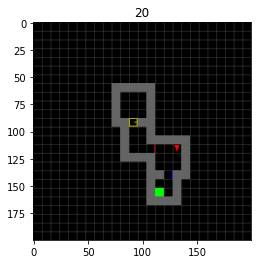

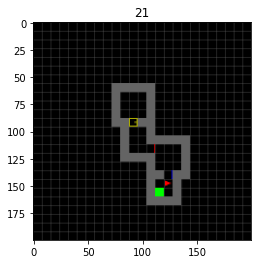

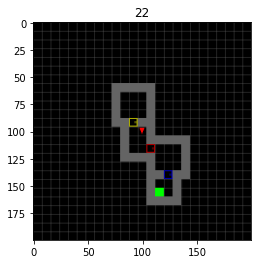

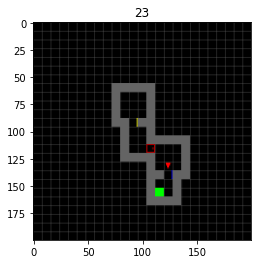

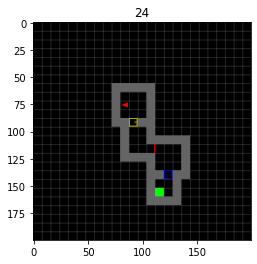

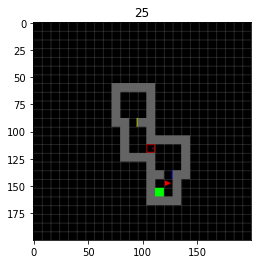

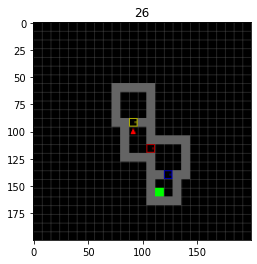

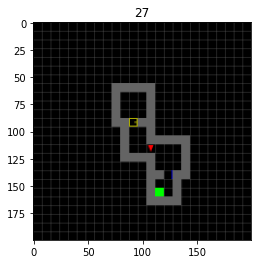

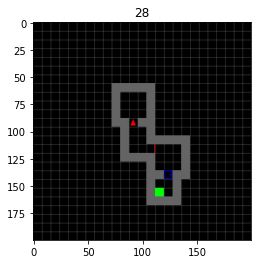

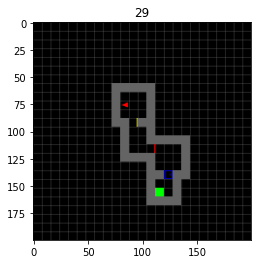

In [968]:
for i, obs in enumerate(observations):
    render_landmark(obs, str(i))

In [1007]:
start_pos = env.start_info[1]
goal_pos = env.goal_info[1]

Oracle start: 0
Oracle goal: 1


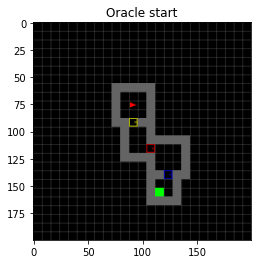

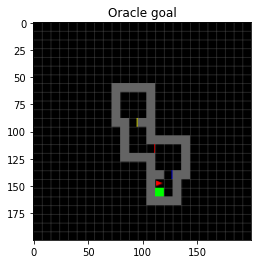

In [1008]:
start_landmark = get_oracle_distance(start_pos[:2]).argmin()
render_landmark(observations[start_landmark], 'Oracle start')

goal_landmark = get_oracle_distance(goal_pos[:2]).argmin()
render_landmark(observations[goal_landmark], 'Oracle goal')

print('Oracle start:', start_landmark)
print('Oracle goal:', goal_landmark)

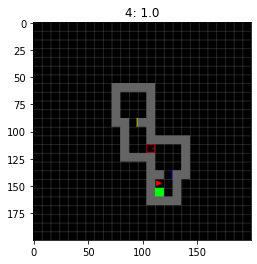

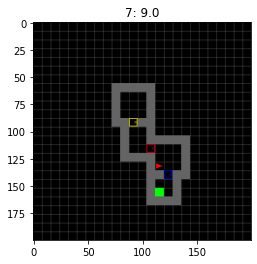

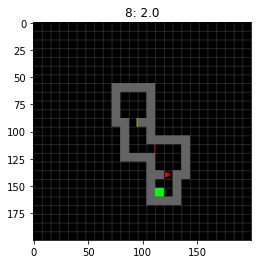

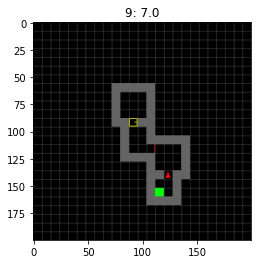

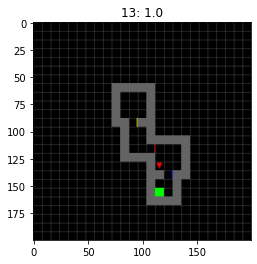

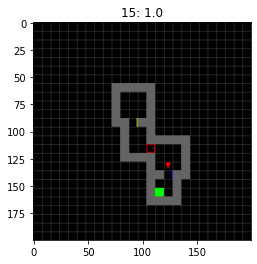

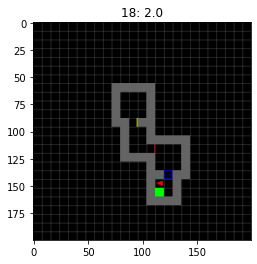

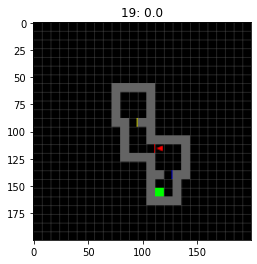

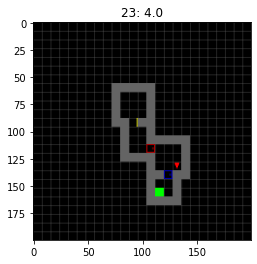

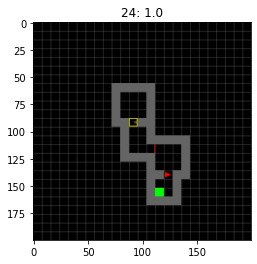

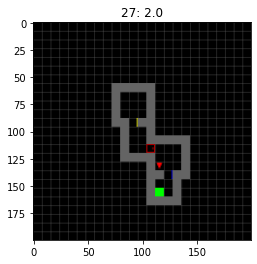

In [772]:
rare = np.arange(N)[random_transitions.sum(axis=0) < 10]
for idx in rare:
    visits = random_transitions[:, idx].sum()
    render_landmark(observations[idx], '{}: {}'.format(idx, visits))

SF start: 0
SF goal: 1


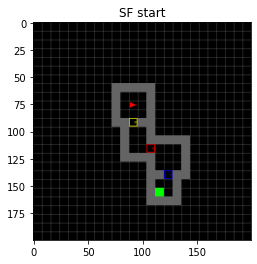

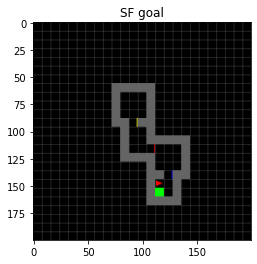

In [1009]:
start_obs, start_sf = get_sf((*start_pos, 0), door_states=[1, 1, 1])
# render_landmark(start_obs, 'start')
start_sim = np.matmul(norm_dsr, start_sf.T).max()
start_landmark = np.matmul(norm_dsr, start_sf.T).argmax()
render_landmark(observations[start_landmark], 'SF start')

goal_obs, goal_sf = get_sf((*goal_pos, 0), door_states=[0, 0, 0])
# render_landmark(goal_obs, 'goal')
goal_sim = np.matmul(norm_dsr, goal_sf.T).max()
goal_landmark = np.matmul(norm_dsr, goal_sf.T).argmax()
render_landmark(observations[goal_landmark], 'SF goal')

print('SF start:', start_landmark)
print('SF goal:', goal_landmark)

In [991]:
dsr_sim[np.eye(N, dtype=bool)] = -1
print(dsr_sim.max(axis=1))
closest = dsr_sim.argmax(axis=1)

[0.94481874 0.9850894  0.9376496  0.9558617  0.9528886  0.9251723
 0.94698215 0.94481874 0.93159455 0.9554856  0.9558617  0.9603841
 0.94526494 0.9512471  0.9623395  0.9554856  0.95709693 0.9642595
 0.93298894 0.9850894  0.94526494 0.93994087 0.9635786  0.94698215
 0.9000002  0.93935925 0.9635786  0.9642595  0.95709693 0.95694995]


Found path: [0, 2, 12, 1]


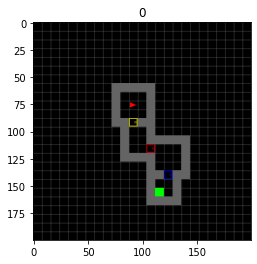

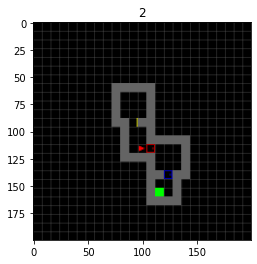

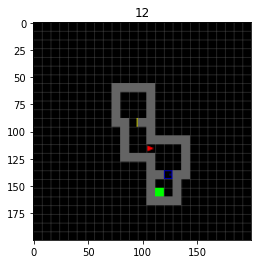

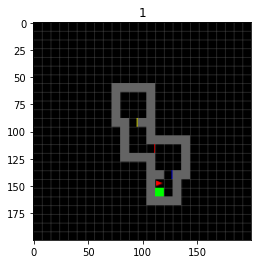

In [1010]:
graph = nx.from_numpy_array(edge_weights)
has_path = nx.has_path(graph, start_landmark, goal_landmark)
if has_path:
    path = nx.shortest_path(graph, start_landmark, goal_landmark, weight='weight')
    print('Found path:', path)
    for idx in path:
        render_landmark(observations[idx], str(idx))
else:
    print('No path from {} to {}'.format(start_landmark, goal_landmark))

array([[0.9992471]], dtype=float32)

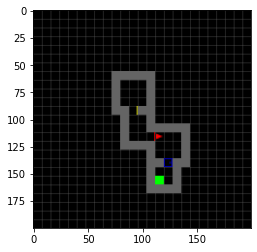

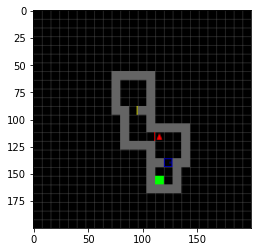

In [642]:
obs_A, sf_A = get_sf([14, 14, 0], door_states=[0, 0, 1])
render_landmark(obs_A)
obs_B, sf_B = get_sf([14, 14, 3], door_states=[0, 0, 1])
render_landmark(obs_B)
np.dot(sf_A, sf_B.T)

In [644]:
dsr_sim[np.eye(len(dsr_sim), dtype=bool)] = -1

In [651]:
closest = dsr_sim.argmax(axis=0)
dsr_sim.max(axis=0)

array([0.9733403 , 0.96526176, 0.97540885, 0.9975132 , 0.96526176,
       0.9977465 , 0.9986613 , 0.9986613 , 0.9977465 , 0.998037  ,
       0.998037  , 1.0000001 , 0.988215  , 0.99671793, 0.98264813,
       0.99671793, 1.0000001 , 0.9922361 , 0.9971415 , 0.99966526,
       0.9946078 , 0.9900138 , 0.9946078 , 0.99689037, 0.9940432 ,
       0.9940432 , 0.9913948 , 0.98264813, 0.9930876 , 0.99689037,
       0.99153113, 0.988215  , 0.98652315, 0.9930876 , 0.98619056,
       0.9848953 , 0.9848953 , 0.9929721 , 0.9657022 , 0.9929721 ,
       0.9970017 , 0.9913948 , 0.9970017 , 0.981362  , 0.99153113,
       0.98255825], dtype=float32)

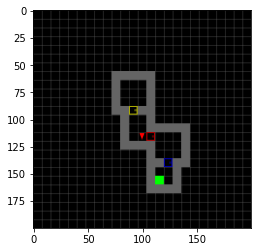

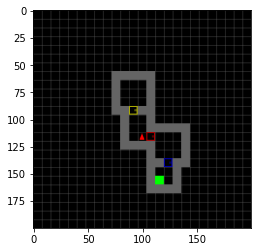

In [655]:
render_landmark(observations[10])
render_landmark(observations[closest[10]])

In [383]:
all_positions = env.get_possible_pos()

In [438]:
grid = np.zeros_like(env.visited, dtype=float) + 0.99

In [439]:
for pos in all_positions: 
    x, y = pos
    pos_obs, pos_sf = get_sf([x, y, 0], [0, 0, 1])
    sim = np.matmul(norm_dsr, pos_sf.T)
    grid[x, y] = sim.max()
#     print(x, y, sim.max())

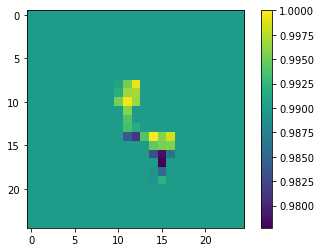

In [440]:
plt.imshow(grid.T)
plt.colorbar()